In [1]:
import torch, torchvision
import detectron2, random
from detectron2.utils.logger import setup_logger
setup_logger()

import matplotlib.path as mplPath
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import os, json, cv2, random
import math, time

from detectron2.utils.visualizer import ColorMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog



In [2]:
def tidy_data(outputs_1):
    new_classes =[]
    new_bbox = []
    global classes
    classes = np.array(outputs_1["instances"].pred_classes.numpy())
    for i in range(len(classes)):
        pred_class = classes[i]
        new_classes.append(pred_class)
        mask_image = outputs_1["instances"].pred_masks.numpy()
        bbox = bounding(mask_image[i,:,:])
        new_bbox.append(bbox[0])
    new_predict = {'classes':np.array(new_classes),'bbox':new_bbox}
    return new_predict


def bounding(mask):
    total_box = []
    mask = np.clip(mask, 0, 255)# 归一化也行
    mask = np.array(mask,np.uint8)
    (cnts, _) = cv2.findContours(mask.copy(),
                                 cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    for c in cnts:
        
        rect = cv2.minAreaRect(c)
        # calculate coordinate of the minimum area rectangle
        box = cv2.boxPoints(rect)
        # normalize coordinates to integers
        box =np.int0(box)
        total_box.append(box)
    return total_box

def is_not_in_other_shrimp2(point,total_matrix):
    x = 0
    for matrix in total_matrix:
        [p1,p2,p3,p4] = matrix
        poly_path = mplPath.Path([p1,p2,p3,p4])
        if poly_path.contains_point(point):
            x+=1
    if x == 1:
        return True
    else:
        return False


def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            label_class = anno["name"]
            class_list = ["shrimp","head","tail"]

            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": class_list.index(label_class),
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts
balloon_metadata = MetadataCatalog.get("new_shrimp_train")

In [3]:
def rebuild_bbox(img,predict):
    all_shrimp = []
    for i in list(np.where(predict['classes']==0)[0]):
        shrimp_bbox = predict['bbox'][i]
        all_shrimp.append(shrimp_bbox.tolist())

    color = [(255,255,0),(0,255,255),(255,0,255)]

    total_shrimp = {}
    clone = img.copy()

    judge_head = all_shrimp.copy()
    judge_tail = all_shrimp.copy()

    for i in list(np.where(predict['classes']==0)[0]):
        head_bbox = []
        tail_bbox = [] 

        pred_class = classes[i]
        draw_bbox = predict['bbox'][int(i)].copy()
        shrimp_bbox = predict['bbox'][int(i)].tolist()
        [p1,p2,p3,p4] = shrimp_bbox
        total_shrimp[str(i)] = {'bbox':shrimp_bbox,
                                'head':{},
                               'tail':{}}

        cv2.drawContours(clone, [draw_bbox], 0, color[0],2 )
        cv2.putText(clone,str(i),tuple(draw_bbox[3].tolist()) ,cv2.FONT_HERSHEY_SIMPLEX,1, 
                    color[pred_class], 2, cv2.LINE_AA)

        poly_path = mplPath.Path([p1,p2,p3,p4])

        
        

        for j in list(np.where(predict['classes']==1)[0]):
            head_bbox = predict['bbox'][int(j)].tolist()
            head_center =  (head_bbox[1][0]/2+head_bbox[3][0]/2,
                            head_bbox[1][1]/2+head_bbox[3][1]/2)
            if poly_path.contains_point(head_center) ==True :
                if is_not_in_other_shrimp2(head_center,judge_head) == True:
                    try:
                        judge_head.remove(shrimp_bbox)
                    except:
                        pass
                    draw_bbox = predict['bbox'][int(j)].copy()
                    cv2.drawContours(clone, [draw_bbox], 0, color[1],2 )
                    cv2.putText(clone,str(j),tuple(draw_bbox[3].tolist()) ,cv2.FONT_HERSHEY_SIMPLEX,1, 
                    color[1], 2, cv2.LINE_AA)
                    head = int(j)
                    total_shrimp[str(i)]['head'][head] = draw_bbox.tolist()
        


        for k in list(np.where(predict['classes']==2)[0]):
            tail_bbox = predict['bbox'][int(k)].tolist()
            tail_center =  (tail_bbox[1][0]/2+tail_bbox[3][0]/2,
                            tail_bbox[1][1]/2+tail_bbox[3][1]/2)
            if poly_path.contains_point(tail_center) == True  : 
                if is_not_in_other_shrimp2(tail_center,judge_tail) == True:
                    try:
                        judge_tail.remove(shrimp_bbox)
                    except:
                        pass
                    draw_bbox = predict['bbox'][int(k)].copy()            
                    cv2.drawContours(clone, [draw_bbox], 0, color[2],2 )
                    cv2.putText(clone,str(k),tuple(draw_bbox[3].tolist()) ,cv2.FONT_HERSHEY_SIMPLEX,1, 
                    color[2], 2, cv2.LINE_AA)
                    tail = int(k)
                    total_shrimp[str(i)]['tail'][tail] = draw_bbox.tolist()

   
    my_dict = total_shrimp.copy()

    
    return my_dict, clone

In [4]:
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"
cfg.DATALOADER.NUM_WORKERS = 2
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 
cfg.MODEL.WEIGHTS = os.path.join('./output', "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [5]:
def caculate_lenght(matrix):
    all_distance = {}
    for i in range(len(matrix)):
        for j in range(i+1,len(matrix)):
            p1 = matrix[i]
            p2 = matrix[j]
            distance = math.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) )
            all_distance[str(i)+'-'+str(j)] = round(distance,2)
    all_distance =dict(sorted(all_distance.items(), key=lambda item: item[1]))
    short_side = list(all_distance.keys())[0:2]
    long_side = list(all_distance.keys())[2:4]
    lenght = (list(all_distance.values())[-3]+list(all_distance.values())[-4])/2
    return all_distance,lenght,short_side,long_side

def caculate_width_1(matrix,mask = 0):
    all_param = {}
    for i in range(len(matrix)):
        for j in range(i+1,len(matrix)):
            p1 = matrix[i]
            p2 = matrix[j]
            if (p1[0]-p2[0] == 0):
                pass
            else:
                a = (p1[1]-p2[1])/(p1[0]-p2[0])
                b = p1[1]-a*p1[0]
                all_param[str(i)+'-'+str(j)] = a
    return all_param

In [6]:
def caculate_width_2(long_sideID,shrimp_bbox):
    p1 = shrimp_bbox[int(long_sideID[0].split('-')[0])]
    p2 = shrimp_bbox[int(long_sideID[0].split('-')[1])]

    new_points1 = []
    for set_point in np.linspace(np.array(p1),np.array(p2),num = 4):
        new_points1.append(set_point.astype(int))
    new_points1 = sorted(new_points1,key = lambda x:x[0])



    p1 = shrimp_bbox[int(long_sideID[1].split('-')[0])]
    p2 = shrimp_bbox[int(long_sideID[1].split('-')[1])]

    new_points2 = []
    for set_point in np.linspace(np.array(p1),np.array(p2),num = 4):
        new_points2.append(set_point.astype(int))
    new_points2 = sorted(new_points2,key = lambda x:x[0])


    reset_point = []
    for i in range(len(new_points1)): 
        new_point = np.concatenate(([new_points1[i]],[new_points2[i]]),axis=0)
        new_point = sorted(new_point,key = lambda x:x[0])
        reset_point.append(new_point)
    return reset_point

def retengle(p1,p2,buffer):
    p1 = np.array(p1)
    p2 = np.array(p2)
    vector = p2-p1
    unit_vector = vector/np.linalg.norm(vector)
    slope = (p2[1]-p1[1])/(p2[0]-p1[0])

    a1 = buffer*np.array([-unit_vector[1],unit_vector[0]])

    new_points = [tuple(p1+a1),tuple(p1-a1),tuple(p2-a1),tuple(p2+a1)]
    points=[]
    for point in new_points:
        new_point = point[1],point[0]
        points.append(new_point)
    return points

def caculate_width_3(reset_point,mask_image,width_buffer):
    all_points = np.argwhere(mask_image == True)
    test_points = []
    length_pixel = []
    for point in reset_point:
        new_points = []
        new_points = retengle(point[0],point[1],width_buffer)        
        path = mplPath.Path(new_points)
        inside = path.contains_points(all_points)
        test_points.append(all_points[inside == True])
        length_pixel.append(len(inside[inside == True]))
    if length_pixel[1]>length_pixel[2]:
        width_index = 1
    else:
        width_index = 2
    width = length_pixel[width_index]/(width_buffer*2)
    return width, length_pixel, test_points, width_index

new_shrimp2/val/4.jpg


/home/ga/anaconda3/envs/detectron/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/ga/anaconda3/envs/detectron/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return to

True

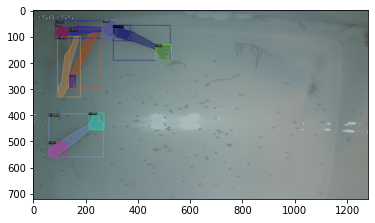

In [7]:
num_0 = random.randint(0,299)
# num_0 = '157'
file_name = "new_shrimp2/val/"+str(num_0)+".jpg"
print(file_name)
im = cv2.imread(file_name)
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
               metadata=balloon_metadata, 
               scale=0.5, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))


predict_image = out.get_image()[:, :, ::-1]
plt.imshow(predict_image)
cv2.imwrite('predict/new_image_'+file_name.split('/')[-1][:-4]+'.png',predict_image)



(1440, 2560, 3)


{'0': {'bbox': [[106, 1067], [486, 779], [563, 880], [183, 1168]],
  'head': {8: [[104, 1072], [206, 977], [260, 1036], [158, 1131]]},
  'tail': {2: [[402, 817], [498, 777], [549, 901], [453, 940]]}},
 '1': {'bbox': [[587, 227], [630, 112], [1058, 271], [1015, 386]],
  'head': {7: [[600, 197], [623, 105], [747, 137], [724, 229]]},
  'tail': {4: [[940, 264], [1054, 264], [1054, 378], [940, 378]]}},
 '3': {'bbox': [[167, 131], [624, 81], [637, 200], [180, 250]],
  'head': {9: [[174, 118], [258, 118], [258, 197], [174, 197]]},
  'tail': {5: [[522, 198], [548, 64], [635, 81], [609, 215]]}},
 '6': {'bbox': [[239, 563], [441, 150], [498, 178], [296, 591]],
  'head': {},
  'tail': {11: [[273, 583], [287, 494], [324, 499], [310, 589]]}},
 '10': {'bbox': [[175, 649], [276, 190], [354, 208], [253, 666]],
  'head': {},
  'tail': {}}}

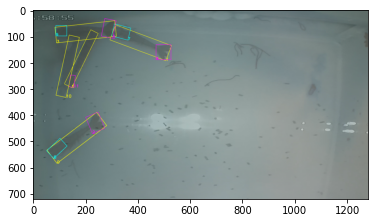

In [8]:
start = time.time()
im2 = cv2.imread(file_name)
outputs_2 = predictor(im2)
new_predict = tidy_data(outputs_2)
my_dict,image = rebuild_bbox(im2,new_predict)

size = image.shape
print(size)
image2 = cv2.resize(image, (size[1]//2, size[0]//2), interpolation=cv2.INTER_AREA)
plt.imshow(image2)

cv2.imwrite('predict/new_image_'+file_name.split('/')[-1][:-4]+'_2.png',image2)
with open('predict/new_image_'+file_name.split('/')[-1][:-4]+'.json', 'w') as fp:
    json.dump(my_dict, fp)

data = my_dict.copy()
pred_masks = outputs["instances"].pred_masks.numpy().copy()
data

In [12]:
def caculate_width(data,pred_masks):
    shrimp_length_width = {}
    for shrimp_num in data:
        shrimp_bbox = data[str(shrimp_num)]['bbox']
        all_lenght, length,short_sideID,long_sideID = caculate_lenght(shrimp_bbox)
        param = caculate_width_1(shrimp_bbox,mask=0)

        mask_image = pred_masks[int(shrimp_num)]
        area = np.count_nonzero(mask_image[mask_image==True])

        reset_point = caculate_width_2(long_sideID,shrimp_bbox)

        width_buffer = 1
        width, length_pixel, test_points, width_index = caculate_width_3(reset_point,mask_image,width_buffer)

        shrimp_length_width[str(shrimp_num)] = {'length':round(length),'width':round(width),'area':area}
    return shrimp_length_width

In [13]:
caculate_width(data,pred_masks)

{'0': {'length': 477, 'width': 72, 'area': 31222},
 '1': {'length': 457, 'width': 72, 'area': 29448},
 '3': {'length': 460, 'width': 60, 'area': 26374},
 '6': {'length': 460, 'width': 54, 'area': 21209},
 '10': {'length': 469, 'width': 64, 'area': 24478}}

{'0': {'length': 477, 'width': 72, 'area': 31222}, '1': {'length': 457, 'width': 72, 'area': 29448}, '3': {'length': 460, 'width': 60, 'area': 26374}, '6': {'length': 460, 'width': 54, 'area': 21209}, '10': {'length': 469, 'width': 64, 'area': 24478}}


Total spend 2.0262272357940674


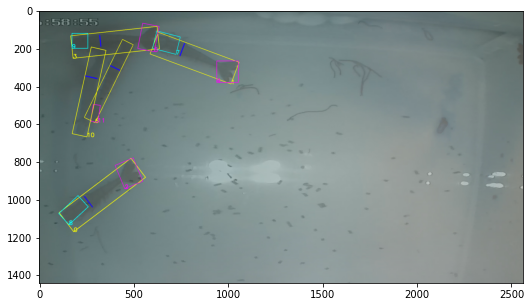

In [11]:
img = image.copy()
shrimp_length_width = {}
for shrimp_num in data:
    shrimp_bbox = data[str(shrimp_num)]['bbox']
    all_lenght, length,short_sideID,long_sideID = caculate_lenght(shrimp_bbox)
    param = caculate_width_1(shrimp_bbox,mask=0)
    
    mask_image = pred_masks[int(shrimp_num)]
    area = np.count_nonzero(mask_image[mask_image==True])
    
    reset_point = caculate_width_2(long_sideID,shrimp_bbox)
    
    width_buffer = 1
    width, length_pixel, test_points, width_index = caculate_width_3(reset_point,mask_image,width_buffer)
    
    shrimp_length_width[str(shrimp_num)] = {'length':round(length),'width':round(width),'area':area}
    
    for point in test_points[width_index]:
        cv2.circle(img,(point[1],point[0]), 2, (25, 10, 255), -1)

plt.figure(figsize=(12,5))
plt.imshow(img)
end = time.time()


with open('predict/new_image_'+file_name.split('/')[-1][:-4]+'_lengthAndwidth.json', 'w') as fp:
    json.dump(shrimp_length_width, fp)
print(shrimp_length_width)
print('\n')
print(f"Total spend {end-start}")

